In [1]:
import os
import sys
from glob import glob
from tqdm import tqdm
import math
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import cv2

import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader
import albumentations as A
sys.path.insert(0, '../')
from utils import load_json, save_pickle
from model import VanillaEfficientNet, load_model
from dataset import TrainDataset, EvalDataset
from torchvision import transforms
from transform_settings import configure_transform
from albumentations import CenterCrop, Blur, Cutout, Equalize, GaussianBlur, GaussNoise, GlassBlur, GridDistortion, Lambda, MedianBlur, MotionBlur, Normalize, RandomBrightnessContrast, RandomFog, Solarize
from albumentations.pytorch.transforms import ToTensor

In [193]:
transform = transforms.Compose([
    transforms.Resize((512, 384), Image.BILINEAR),
    transforms.CenterCrop((384, 384)),
    # transforms.RandomResizedCrop((224, 224)),
    ])

data_config = {
    'root': '../preprocessed_stratified/train', 
    'transform': None, 
    'task': 'main',
    'meta_path': '../preprocessed_stratified/metadata.json'
    }
dataset = TrainDataset(**data_config)
model = VanillaEfficientNet(n_class=18)
loader = DataLoader(dataset, batch_size=4)

Loaded pretrained weights for efficientnet-b3


In [204]:
def get_similarity(pixel_dist_left, pixel_dist_right):
    """
    픽셀 분포 간 유사도를 측정하는 함수
    분포 간 intersection을 유사도로 가정하여 높을 수록 유사도가 높다
    """
    pixel_dist_left = cv2.cvtColor(pixel_dist_left, cv2.COLOR_RGB2GRAY)
    hist_left = cv2.calcHist(images=[pixel_dist_left], channels=[0], mask=None, histSize=[32], ranges=[0,256])
    pixel_dist_right = cv2.cvtColor(pixel_dist_right, cv2.COLOR_RGB2GRAY)
    hist_right = cv2.calcHist(images=[pixel_dist_right], channels=[0], mask=None, histSize=[32], ranges=[0,256])
    similarity = cv2.compareHist(H1=hist_left, H2=hist_right, method=cv2.HISTCMP_INTERSECT)
    return similarity

def split_image(img: np.array, v, scale):
    """수직선을 기준으로 이미지를 분할
    좌우로 이미지를 분할했을 때, 가로 길이가 같도록 가로 길이를 조정
    """
    if v >= scale:
        margin = scale - v%scale
        pixel_dist_left = img[:, v-margin:v]
        pixel_dist_right = img[:, v:]
    else:
        margin = v%scale
        pixel_dist_left = img[:, :v]
        pixel_dist_right = img[:, v:v+margin]
    return pixel_dist_left, pixel_dist_right


def get_center_vline(img, scale: int=64, rescaled=True):
    transform = transforms.Resize((int(scale*(4/3)), scale))

    v_list = [i+int(scale*(2/5)) for i in range(scale//5)][::2]
    margin_list = [i+int(scale*(2/5)) for i in range(scale//5)][::2]

    img_resized = np.array(transform(img))
    importances = np.zeros(len(v_list))

    for idx, v in enumerate(v_list):
        pixel_dist_left, pixel_dist_right = split_image(img_resized, v, scale)
        similarity = get_similarity(pixel_dist_left, pixel_dist_right)
        importances[idx] += (similarity / (v*scale)) # normalize

    v = v_list[np.argsort(importances)[3]]

    if rescaled: # 입력할 때의 이미지 크기에 맞게 수직선의 위치를 조정
        origin_v_length = np.array(img).shape[1]
        v = int(origin_v_length * (v / scale))

    return v

def get_vline(img_resized: np.array, scale: int=64):
    v_list = [i+int(scale*(2/5)) for i in range(scale//5)][::2]
    margin_list = [i+int(scale*(2/5)) for i in range(scale//5)][::2]
    importances = np.zeros(len(v_list))

    for idx, v in enumerate(v_list):
        pixel_dist_left, pixel_dist_right = split_image(img_resized, v, scale)
        similarity = get_similarity(pixel_dist_left, pixel_dist_right)
        importances[idx] += (similarity / (v*scale)) # normalize
    v = v_list[np.argsort(importances)[3]]
    return v


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


def get_hline(img: np.array, v, scale: int=64):
    SHIFT = 1
    UPPER_QUANTILE = 0.65   
    LOWER_QUANTILE = 0.35

    # Use SMA for calculating gradient
    v0 = moving_average(img[:, v], 14) # 단순이동평균
    v1 = np.roll(v0, shift=SHIFT, axis=0)
    v_interval = v0.shape[0]

    h_lower = np.argmax(np.abs(v0[int(v_interval*LOWER_QUANTILE):-SHIFT] - v1[int(v_interval*LOWER_QUANTILE):-SHIFT])) + int(v_interval*0.6)
    h_upper = np.argmax(np.abs(v0[SHIFT:int(v_interval*LOWER_QUANTILE)] - v1[SHIFT:int(v_interval*LOWER_QUANTILE)]))
    print(h_lower, h_upper)

    return h_lower, h_upper

def crop(img, scale: int=64, rescaled=True):
    transform = transforms.Resize((int(scale*(4/3)), scale))
    img_resized = np.array(transform(img))

    vline = get_vline(img_resized, scale)
    h_lower, h_upper = get_hline(img_resized, vline, scale)

    if rescaled: # 입력할 때의 이미지 크기에 맞게 수직선의 위치를 조정
        origin_v_scale = np.array(img).shape[1]
        origin_h_scale = np.array(img).shape[0]
        vline = int(origin_v_scale * (vline / scale))
        h_lower = int(origin_h_scale * (h_lower / scale))
        h_upper = int(origin_h_scale * (h_upper / scale))
        print(h_lower, h_upper)

    hline = int((h_lower + h_upper) / 2)
    # hline = int(math.sqrt((np.array(img).shape[0] - h_lower) * (np.array(img).shape[0] - h_upper) ))
    height = h_lower - h_upper

    return (hline, vline), height

In [201]:
transform = transforms.Resize((int(scale*(4/3)), scale))
img_resized = np.array(transform(img))

In [203]:
i = 2

(hline, vline), height = crop(dataset[i][0])

# plt.imshow(dataset[i][0])

# coord_x = (0, 384)
# coord_h = (hline, hline)

# # coord_y = (center[1] - height, center[1] + height)
# coord_y = (0, 512)
# coord_v = (vline, vline)

# plt.plot(coord_x, coord_h, color='red') # hline
# plt.plot(coord_v, coord_y, color='red') # hline
# plt.show()

ValueError: object too deep for desired array

In [65]:
h1, h2

(47, 21)

In [67]:
original_h_length = np.array(sample).shape[0]
original_h_length * (h1 / scale), original_h_length * (h2 / scale)

(376.0, 168.0)

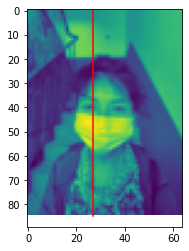

In [154]:
sample = dataset[48][0]
v = get_center_vline(sample)

sample_resized = np.array(transform(sample))
blurred_gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)

coord_x = (v, v)
coord_y = (0, 85)
plt.imshow(blurred_gray)
plt.plot(coord_x, coord_y, c='red')
plt.show()

In [55]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [56]:
sample = dataset[1000][0]
v = get_center_vline(img=sample, rescaled=False)

In [62]:
scale = 64
transform = transforms.Compose([
    transforms.Resize((int(scale*(4/3)), scale))
    ])
print((int(scale*(4/3)), scale))
img_resized = np.array(transform(sample))
img_resized = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)

(85, 64)


In [ ]:
original_h_length = np.array(sample).shape[0]
original_h_length * (h1 / scale), original_h_length * (h2 / scale)

In [70]:
rescaled = True

v0 = moving_average(img_resized[:, v], 7) # 단순이동평균
v1 = np.roll(v0, shift=1, axis=0)

length = v0.shape[0]
h1 = np.argmax(np.abs(v0[int(length*0.65):-1] - v1[int(length*0.65):-1])) + int(length*0.6)
h2 = np.argmax(np.abs(v0[1:int(length*0.35)] - v1[1:int(length*0.35)]))

if rescaled:
    original_h_length = np.array(sample).shape[0]
    h1 = int(original_h_length * (h1 / scale))
    h2 = int(original_h_length * (h2 / scale))

center = (h1 + h2) // 2
height = h1 - h2

center, height

(272, 208)

In [ ]:
origin_v_length = np.array(img).shape[1]

In [61]:
center

34

(512, 384, 3)

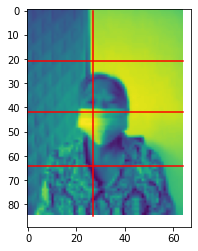

In [199]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

MOD = 64
transform = transforms.Compose([
    transforms.Resize((int(MOD*(4/3)), MOD))
    ])

blurred = np.array(transform(sample))
blurred_gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)

v0 = moving_average(blurred_gray[:, v], 7) # 단순이동평균
v1 = np.roll(v0, shift=1, axis=0)
length = v0.shape[0]
h1 = np.argmax(np.abs(v0[int(length*0.65):-1] - v1[int(length*0.65):-1])) + int(length*0.6)
h2 = np.argmax(np.abs(v0[1:int(length*0.35)] - v1[1:int(length*0.35)]))

coord_v = (v, v)
coord_y = (0, 85)

coord_x = (0, 64)
coord_h1 = (h1, h1)
coord_h2 = (h2, h2)

h = (h1 + h2) // 2
coord_h = (h, h)

plt.imshow(blurred_gray)
plt.plot(coord_x, coord_h1, c='red')
plt.plot(coord_x, coord_h2, c='red')
plt.plot(coord_x, coord_h, c='red')
plt.plot(coord_v, coord_y, c='red')
np.array(sample).shape